# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../data/input/input_dataset.csv')

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsConceded,HTGoalsDiff,Points,WinPercent,WinStreak,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,PromotedMatchup,WinnerOdd,DrawOdd,Venue,Result
0,L Probert,Sat,1.0,-4,10.4,6.6,3.8,-1.8,0.0,0.0,0.8,0.4,2.0,0.0,0.4,-2.0,0.4,20.0,0.0,0.0,1.0,7,8,8,7.67,-12,0,-9.71,5.50,Etihad Stadium,W
1,M Halsey,Sat,1.0,1,-1.0,-0.2,0.0,-1.8,0.4,0.0,0.2,0.0,1.0,0.4,0.2,1.0,-0.2,0.0,0.0,-20.0,-1.0,1,1,-2,0.00,1,0,-2.25,3.30,Bet365 Stadium,D
2,L Mason,Sat,1.0,0,6.8,5.0,1.8,-0.2,0.4,0.2,1.6,0.6,5.0,1.4,1.0,2.0,0.4,0.0,0.0,40.0,7.0,3,0,-1,0.67,-6,0,-6.56,4.20,Goodison Park,W
3,L Probert,Sun,1.0,0,3.4,2.2,2.0,0.2,-0.6,0.0,1.8,0.6,6.0,0.4,0.4,0.0,1.0,20.0,0.0,60.0,5.0,1,2,1,1.34,-4,0,-3.58,3.75,Craven Cottage,L
4,P Dowd,Sun,1.0,-1,-2.4,-1.8,-0.6,0.6,-1.0,0.0,-0.4,-1.2,4.0,0.2,0.0,1.0,1.0,20.0,0.0,60.0,6.0,-1,-3,-5,-3.00,-1,0,-1.50,3.30,Carrow Road,W


In [4]:
# label encode categorical feature- Day Of Week
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode categorical feature- Referee
referee_le = LabelEncoder()
df['Referee'] = referee_le.fit_transform(df['Referee'])

# label encode categorical feature- Venue
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

# 3. Feature Selection

In [5]:
selected_features = ['Referee', 'Shots', 'Corners', 'Points', 'UnbStreak', 'LastSeasonRank', 'PromotedMatchup', 'Venue']

# 4. Model Building- Data Split 2

- Target Variable: Draw/ Non-Draw
- Balanced Sampling

### Random Forest Classifier

#### Hyperparameter Tuning using Fold 1

In [6]:
# data splitting
train_set = pd.read_csv('./fold-1/train.csv')
test_set = pd.read_csv('./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 200}


#### Fold 1

In [6]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='log2', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


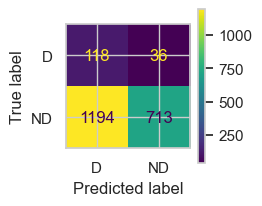

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [8]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4032023289665211
ROC score on Test Set: 0.5876640402073019

              precision    recall  f1-score   support

           0       0.09      0.77      0.16       154
           1       0.95      0.37      0.54      1907

    accuracy                           0.40      2061
   macro avg       0.52      0.57      0.35      2061
weighted avg       0.89      0.40      0.51      2061



#### Fold 2

In [9]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='log2', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


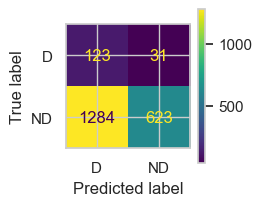

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.36196021348859775
ROC score on Test Set: 0.5698179638924263

              precision    recall  f1-score   support

           0       0.09      0.80      0.16       154
           1       0.95      0.33      0.49      1907

    accuracy                           0.36      2061
   macro avg       0.52      0.56      0.32      2061
weighted avg       0.89      0.36      0.46      2061



#### Fold 3

In [12]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='log2', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


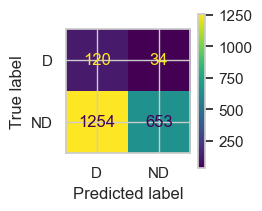

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.3750606501698205
ROC score on Test Set: 0.5915458427257063

              precision    recall  f1-score   support

           0       0.09      0.78      0.16       154
           1       0.95      0.34      0.50      1907

    accuracy                           0.38      2061
   macro avg       0.52      0.56      0.33      2061
weighted avg       0.89      0.38      0.48      2061



#### Fold 4

In [15]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='log2', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


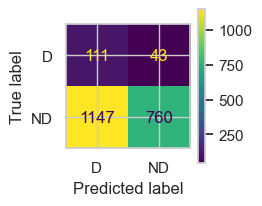

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.42261038330907325
ROC score on Test Set: 0.5797523137586064

              precision    recall  f1-score   support

           0       0.09      0.72      0.16       154
           1       0.95      0.40      0.56      1907

    accuracy                           0.42      2061
   macro avg       0.52      0.56      0.36      2061
weighted avg       0.88      0.42      0.53      2061



#### Fold 5

In [18]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='log2', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


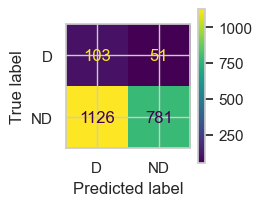

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4289180009704027
ROC score on Test Set: 0.5627387819312308

              precision    recall  f1-score   support

           0       0.08      0.67      0.15       154
           1       0.94      0.41      0.57      1907

    accuracy                           0.43      2061
   macro avg       0.51      0.54      0.36      2061
weighted avg       0.87      0.43      0.54      2061



### Logistic Regression

#### Hyperparamter Tuning using Fold 1

In [21]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.004832930238571752, 'penalty': 'l2', 'solver': 'liblinear'}


#### Fold 1

In [54]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0048, penalty='l2', solver='liblinear', random_state = 0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


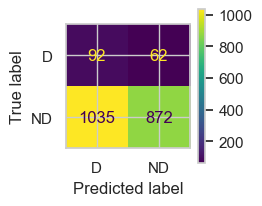

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.46773410965550705
ROC score on Test Set: 0.550425976750046

              precision    recall  f1-score   support

           0       0.08      0.60      0.14       154
           1       0.93      0.46      0.61      1907

    accuracy                           0.47      2061
   macro avg       0.51      0.53      0.38      2061
weighted avg       0.87      0.47      0.58      2061



#### Fold 2

In [57]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0048, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


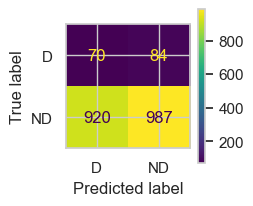

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5128578360019408
ROC score on Test Set: 0.5213124578620121

              precision    recall  f1-score   support

           0       0.07      0.45      0.12       154
           1       0.92      0.52      0.66      1907

    accuracy                           0.51      2061
   macro avg       0.50      0.49      0.39      2061
weighted avg       0.86      0.51      0.62      2061



#### Fold 3

In [60]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0048, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


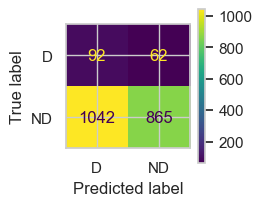

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4643377001455604
ROC score on Test Set: 0.5364038164247917

              precision    recall  f1-score   support

           0       0.08      0.60      0.14       154
           1       0.93      0.45      0.61      1907

    accuracy                           0.46      2061
   macro avg       0.51      0.53      0.38      2061
weighted avg       0.87      0.46      0.58      2061



#### Fold 4

In [63]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0048, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


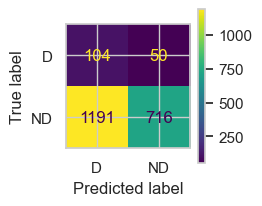

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [65]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.3978651140223193
ROC score on Test Set: 0.5379463221623683

              precision    recall  f1-score   support

           0       0.08      0.68      0.14       154
           1       0.93      0.38      0.54      1907

    accuracy                           0.40      2061
   macro avg       0.51      0.53      0.34      2061
weighted avg       0.87      0.40      0.51      2061



#### Fold 5

In [66]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0048, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


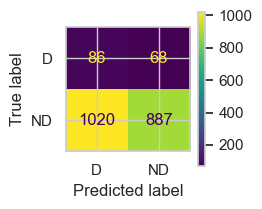

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [68]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4721009218825813
ROC score on Test Set: 0.512874645019375

              precision    recall  f1-score   support

           0       0.08      0.56      0.14       154
           1       0.93      0.47      0.62      1907

    accuracy                           0.47      2061
   macro avg       0.50      0.51      0.38      2061
weighted avg       0.87      0.47      0.58      2061



### SVM Classifier

#### Hyperparameter Tuning using Fold 1

In [22]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 0.1, 'tol': 1}


#### Fold 1

In [24]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


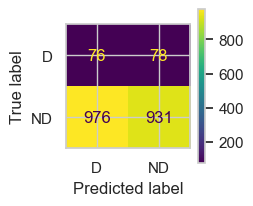

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4885977680737506
ROC score on Test Set: 0.4824842174081817

              precision    recall  f1-score   support

           0       0.07      0.49      0.13       154
           1       0.92      0.49      0.64      1907

    accuracy                           0.49      2061
   macro avg       0.50      0.49      0.38      2061
weighted avg       0.86      0.49      0.60      2061



#### Fold 2

In [27]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


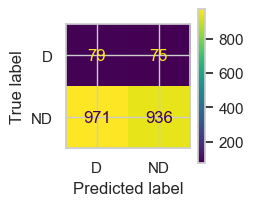

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.492479378942261
ROC score on Test Set: 0.5169811834730555

              precision    recall  f1-score   support

           0       0.08      0.51      0.13       154
           1       0.93      0.49      0.64      1907

    accuracy                           0.49      2061
   macro avg       0.50      0.50      0.39      2061
weighted avg       0.86      0.49      0.60      2061



#### Fold 3

In [30]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


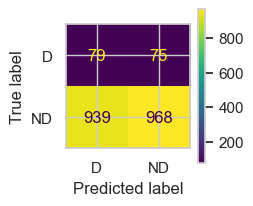

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5080058224163028
ROC score on Test Set: 0.5356274559211109

              precision    recall  f1-score   support

           0       0.08      0.51      0.13       154
           1       0.93      0.51      0.66      1907

    accuracy                           0.51      2061
   macro avg       0.50      0.51      0.40      2061
weighted avg       0.86      0.51      0.62      2061



#### Fold 4

In [33]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


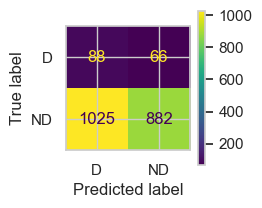

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [35]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.47064531780688984
ROC score on Test Set: 0.49137490721129945

              precision    recall  f1-score   support

           0       0.08      0.57      0.14       154
           1       0.93      0.46      0.62      1907

    accuracy                           0.47      2061
   macro avg       0.50      0.52      0.38      2061
weighted avg       0.87      0.47      0.58      2061



#### Fold 5

In [36]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


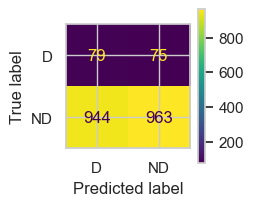

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5055798156234838
ROC score on Test Set: 0.5137872091201929

              precision    recall  f1-score   support

           0       0.08      0.51      0.13       154
           1       0.93      0.50      0.65      1907

    accuracy                           0.51      2061
   macro avg       0.50      0.51      0.39      2061
weighted avg       0.86      0.51      0.62      2061



### XGBoost Classifier

#### Hyperparamter Tuning using Fold 1

In [23]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 140}


#### Fold 1

In [39]:
# XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


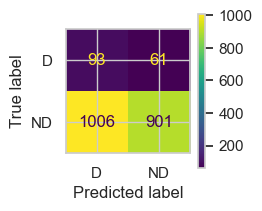

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4822901504124212
ROC score on Test Set: 0.5573621449342477

              precision    recall  f1-score   support

           0       0.08      0.60      0.15       154
           1       0.94      0.47      0.63      1907

    accuracy                           0.48      2061
   macro avg       0.51      0.54      0.39      2061
weighted avg       0.87      0.48      0.59      2061



#### Fold 2

In [42]:
# XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=140)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


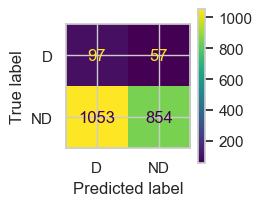

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.46142649199417757
ROC score on Test Set: 0.5471639005986149

              precision    recall  f1-score   support

           0       0.08      0.63      0.15       154
           1       0.94      0.45      0.61      1907

    accuracy                           0.46      2061
   macro avg       0.51      0.54      0.38      2061
weighted avg       0.87      0.46      0.57      2061



#### Fold 3

In [45]:
# XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=140)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


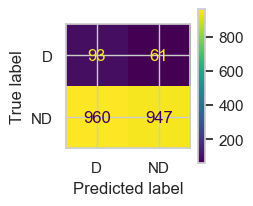

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [47]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5046094129063562
ROC score on Test Set: 0.5705636785867515

              precision    recall  f1-score   support

           0       0.09      0.60      0.15       154
           1       0.94      0.50      0.65      1907

    accuracy                           0.50      2061
   macro avg       0.51      0.55      0.40      2061
weighted avg       0.88      0.50      0.61      2061



#### Fold 4

In [48]:
# XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=140)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


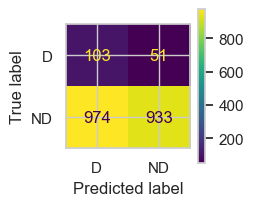

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [50]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.502668607472101
ROC score on Test Set: 0.5808998290644856

              precision    recall  f1-score   support

           0       0.10      0.67      0.17       154
           1       0.95      0.49      0.65      1907

    accuracy                           0.50      2061
   macro avg       0.52      0.58      0.41      2061
weighted avg       0.88      0.50      0.61      2061



#### Fold 5

In [51]:
# XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=140)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'ND': 1})
y_test = y_test.map({'D': 0, 'ND': 1})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    618
0    618
Name: Result, dtype: int64
1    1907
0     154
Name: Result, dtype: int64


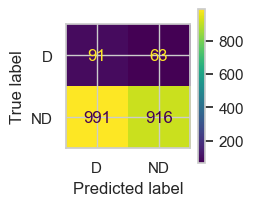

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'ND'])
cmp.plot(ax=ax)

plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4885977680737506
ROC score on Test Set: 0.5593541225423764

              precision    recall  f1-score   support

           0       0.08      0.59      0.15       154
           1       0.94      0.48      0.63      1907

    accuracy                           0.49      2061
   macro avg       0.51      0.54      0.39      2061
weighted avg       0.87      0.49      0.60      2061

